In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on']
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
df = prepare('datasets/samples.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11503813 entries, 0 to 11503812
Data columns (total 5 columns):
device_id         uint16
timestamp         datetime64[ns]
battery_level     uint8
network_status    object
screen_on         uint8
dtypes: datetime64[ns](1), object(1), uint16(1), uint8(2)
memory usage: 219.4+ MB


In [4]:
df['change'] = df.battery_level - df.battery_level.shift()
df.loc[df.device_id != df.device_id.shift(), 'change'] = None

In [5]:
def show_hist(s, bins, title, end=None, start=0, step=1, ylabel='# Samples', color='#66b3ff'):
    s.hist(bins=bins, color=color, edgecolor='k', linewidth=.5, figsize=(12,6))
    if (end != None):
        plt.xticks(np.arange(start, end, step))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

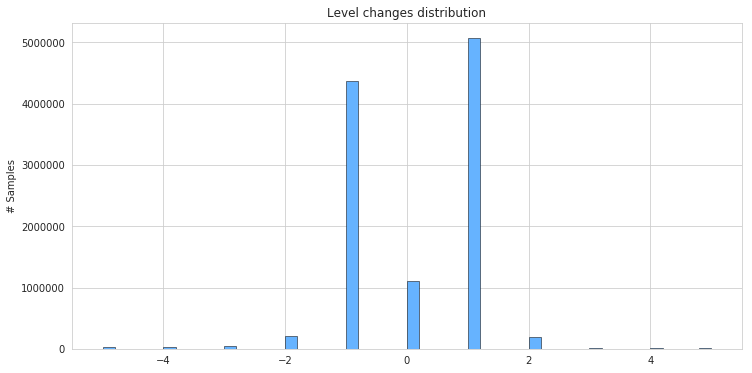

In [6]:
interval = 5

gl = df[(df['change'] >= -interval) & (df['change'] <= interval)]

show_hist(gl['change'], 50, 'Level changes distribution')

In [7]:
df['change_acc'] = df['change'].cumsum()
df.loc[df.device_id != df.device_id.shift(), 'change_acc'] = None

In [8]:
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['time_acc'] = df['time_diff'].cumsum()
df.loc[df.device_id != df.device_id.shift(), 'time_acc'] = None

In [9]:
df.head()

,device_id,timestamp,battery_level,network_status,screen_on,change,change_acc,time_diff,time_acc
0,1,2017-10-15 18:36:46,99,lte,1,NaN,NaN,NaN,NaN
1,1,2017-10-15 18:41:54,98,lte,1,-1.0,-1.0,308.0,308.0
2,1,2017-10-15 18:46:54,97,lte,1,-1.0,-2.0,300.0,608.0
3,1,2017-10-15 18:50:35,96,lte,1,-1.0,-3.0,221.0,829.0
4,1,2017-10-15 18:54:14,95,lte,1,-1.0,-4.0,219.0,1048.0
